In [ ]:
#Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Input, UpSampling2D, BatchNormalization, Conv2DTranspose
from keras.layers.convolutional import Deconvolution2D 
from keras.models import Model
from keras.activations import relu,sigmoid,tanh
import sklearn

In [ ]:
#Mounting drive folder to colab for access of features and labels data
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
cd '/content/drive/My Drive/Btech - Mechanical Engineering/Sem 5/ME504 Deep Learning Physical Systems'

/content/drive/My Drive/Btech - Mechanical Engineering/Sem 5/ME504 Deep Learning Physical Systems


In [ ]:
'''
Data Set Source:
Edalatifar, Mohammad; Tavakoli, Mohammad Bagher; Ghalambaz, Mohammad; Setoudeh, Farbod (2020),
“A dataset for conduction heat transer and deep learning”, Mendeley Data, V1, doi: 10.17632/rw9yk3c559.1
'''

Data = np.load('./HeatTransferPhenomena_35_58.npz')
xTrain = Data['xTrain']
yTrain = Data['yTrain']
xTest = Data['xTest']
yTest = Data['yTest']
xValidation = Data['xValidation']
yValidation = Data['yValidation']

del Data

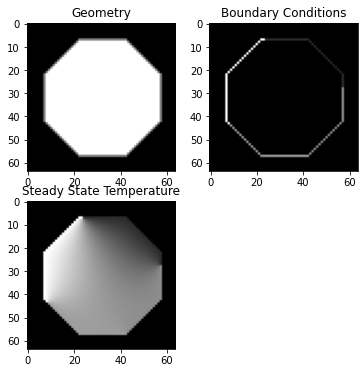

In [ ]:
#Visualising the Input and Desired Output of the model
plt.figure(figsize=[6,6])
plt.subplot(2,2,1)
plt.imshow(xTrain[1,:,:,0],cmap='gray')
plt.title("Geometry")
plt.subplot(2,2,2)
plt.imshow(xTrain[1,:,:,1],cmap='gray')
plt.title("Boundary Conditions")
plt.subplot(2,2,3)
plt.imshow(yTrain[1,:,:,0],cmap='gray')
plt.title("Steady State Temperature")
plt.show()

#Building the DNN Model

In [ ]:
#Bulding the autoencoder model without the feed-forward residual block
"""The auto encoder has 3 stages which are encoder,bottleneck and decoder. The encoder extracts the features from the input and stores it in 
the bottleneck. The decoder constructs the output from the bottleneck features."""

ip = Input(shape=(64, 64, 2))

enc = Conv2D(16, (3, 3), activation='relu', padding='same',strides=(1,1))(ip)
enc = Conv2D(32, (3, 3), activation='relu', padding='same',strides=(2,2))(enc)
enc = Conv2D(64, (3, 3), activation='relu', padding='same',strides=(2,2))(enc)
enc = Conv2D(128, (3, 3), activation='relu', padding='same',strides=(2,2))(enc)
enc_op = Conv2D(256, (3, 3), activation='relu', padding='same',strides=(2,2))(enc)

dec = Conv2D(256, (3, 3), activation='relu', padding='same')(enc_op)
dec = UpSampling2D((2,2))(dec)
dec = Conv2D(128, (3, 3), activation='relu', padding='same')(dec)
dec = UpSampling2D((2, 2))(dec)
dec = Conv2D(64, (3, 3), activation='relu', padding='same')(dec)
dec = UpSampling2D((2, 2))(dec)
dec = Conv2D(32, (3, 3), activation='relu', padding='same')(dec)
dec = UpSampling2D((2, 2))(dec)
dec = Conv2D(16, (3, 3), activation='relu', padding='same')(dec)

dec_op = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(dec)


autoencoder = Model(ip, dec_op)
autoencoder.compile(optimizer='rmsprop', loss='mse') 

In [ ]:
#Model Summary
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 2)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        304       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 256)         590080

In [ ]:
autoencoder.fit(x=xTrain,y=yTrain,validation_data=(xValidation,yValidation),epochs=3)

Epoch 1/3
966/966 [==============================] - 768s 794ms/step - loss: 0.1055 - val_loss: 0.1036
Epoch 2/3
966/966 [==============================] - 763s 790ms/step - loss: 0.1045 - val_loss: 0.1036
Epoch 3/3
966/966 [==============================] - 764s 791ms/step - loss: 0.1051 - val_loss: 0.1036


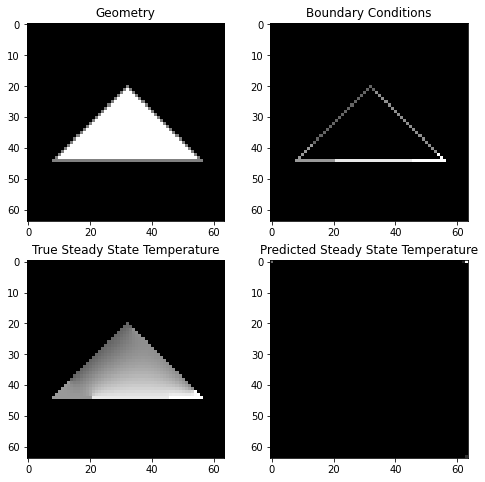

In [ ]:
#Visualising the predicted and desired output
n=1
predicted=autoencoder.predict(xTest[n].reshape((1,64,64,2)))

plt.figure(figsize=[8,8])
plt.subplot(2,2,1)
plt.imshow(xTest[n,:,:,0],cmap='gray')
plt.title("Geometry")
plt.subplot(2,2,2)
plt.imshow(xTest[n,:,:,1],cmap='gray')
plt.title("Boundary Conditions")
plt.subplot(2,2,3)
plt.imshow(yTest[n,:,:,0],cmap='gray')
plt.title("True Steady State Temperature")
plt.subplot(2,2,4)
plt.imshow(predicted[0,:,:,0],cmap='gray')
plt.title("Predicted Steady State Temperature")
plt.show()

As we can see here the model fails to converege to the desired function quickly, we will try to over come this problem in the following model by using a Residual Neural Network which enhances the training process using a feedforward mechanism.

#ResNet

In [ ]:
class Residual_encoder(Model):
    def __init__(self, kernels, strides=1):
      #Initialising the variables of the residual block
      """Here we have initalised 3 batch normalization functions along with 3 Convolution functions"""
      super().__init__()
      self.batch_norm1 = BatchNormalization()
      self.batch_norm2 = BatchNormalization()
      self.batch_norm3 = BatchNormalization()
        
      self.conv1 = Conv2D(kernels, padding='same', kernel_size=3, strides=strides)
      self.conv2 = Conv2D(kernels, kernel_size=3, padding='same')
      self.conv3 = Conv2D(kernels, kernel_size=1, strides=strides, padding='same')

    def call(self, X,activation_fn=relu):
      """Once the function is called, we will be transforming the input by performing batch normalization, activation and DeConvolution respectively"""
      Y = self.conv1(activation_fn(self.batch_norm1(X)))
      Y = self.conv2(activation_fn(self.batch_norm2(Y)))
      X = self.conv3(activation_fn(self.batch_norm3(X)))
      #Performing feed forward on the data to retain information in the input
      Y += X
      return Y

In [ ]:
class Residual_decoder(Model):
    def __init__(self, kernels, strides=1):
      #Initialising the variables of the residual block
      """Here we have initalised 3 batch normalization functions along with 3 DeConvolution functions"""
      super().__init__()
      self.batch_norm1 = BatchNormalization()
      self.batch_norm2 = BatchNormalization()
      self.batch_norm3 = BatchNormalization()
        
      self.conv1 = Conv2DTranspose(kernels, padding='same', kernel_size=3, strides=strides)
      self.conv2 = Conv2DTranspose(kernels, kernel_size=3, padding='same')
      self.conv3 = Conv2DTranspose(kernels, kernel_size=1, strides=strides)

    def call(self, X,activation_fn=relu):
      """Once the function is called, we will be transforming the input by performing batch normalization, activation and DeConvolution respectively"""
      Y = self.conv1(activation_fn(self.batch_norm1(X)))
      Y = self.conv2(activation_fn(self.batch_norm2(Y)))
      X = self.conv3(activation_fn(self.batch_norm3(X)))
      #Performing feed forward on the data to retain information in the input
      Y += X
      return Y

### ReLu Activation

In [ ]:
#Constructing the autoencoder model with feed-forward residual block and mse loss function and adam optimizer and ReLu activation function
ip = Input(shape=(64, 64, 2))

enc = Residual_encoder(16)(ip)
enc = Residual_encoder(32,2)(enc)
enc = Residual_encoder(64,2)(enc)
enc = Residual_encoder(128,2)(enc)
enc_op = Residual_encoder(256,2)(enc)

dec = Residual_decoder(128,2)(enc_op)
dec = Residual_decoder(64,2)(dec)
dec = Residual_decoder(32,2)(dec)
dec = Residual_decoder(16,2)(dec)
dec = Residual_decoder(1)(dec)
dec_op = sigmoid(dec)

autoencoder = Model(ip, dec_op)
autoencoder.compile(optimizer='adam', loss='mse') 

In [ ]:
#Model summary
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 2)]       0         
_________________________________________________________________
residual_encoder (Residual_e (None, 64, 64, 16)        2752      
_________________________________________________________________
residual_encoder_1 (Residual (None, 32, 32, 32)        14688     
_________________________________________________________________
residual_encoder_2 (Residual (None, 16, 16, 64)        58048     
_________________________________________________________________
residual_encoder_3 (Residual (None, 8, 8, 128)         230784    
_________________________________________________________________
residual_encoder_4 (Residual (None, 4, 4, 256)         920320    
_________________________________________________________________
residual_decoder (Residual_d (None, 8, 8, 128)         478080

In [ ]:
#Fit the model to the given training data
autoencoder.fit(x=xTrain,y=yTrain,validation_data=(xValidation,yValidation),epochs=3)

Epoch 1/3
966/966 [==============================] - 1353s 1s/step - loss: 0.0314 - val_loss: 0.0105
Epoch 2/3
966/966 [==============================] - 1399s 1s/step - loss: 0.0020 - val_loss: 7.4955e-04
Epoch 3/3
966/966 [==============================] - 1359s 1s/step - loss: 8.0809e-04 - val_loss: 7.3952e-04


In [ ]:
#Saving the weights of the trained model
autoencoder.save_weights('./ResNet_ReLu.h5')

In [ ]:
#Run this code to load the trained weights
autoencoder.load_weights('./ResNet_ReLu.h5')

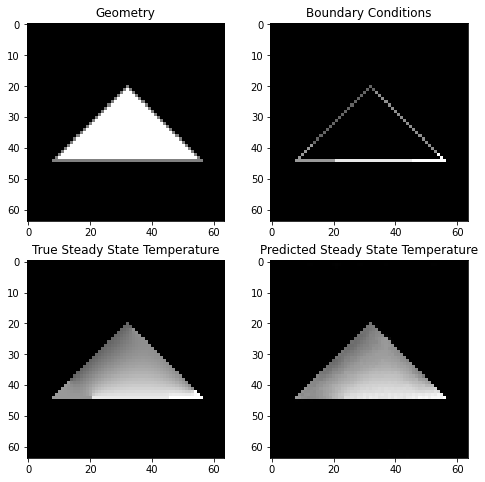

In [ ]:
#Visualising a sample to see if the model is accurate
n=1
predicted=autoencoder.predict(xTest[n].reshape((1,64,64,2)))

plt.figure(figsize=[8,8])
plt.subplot(2,2,1)
plt.imshow(xTest[n,:,:,0],cmap='gray')
plt.title("Geometry")
plt.subplot(2,2,2)
plt.imshow(xTest[n,:,:,1],cmap='gray')
plt.title("Boundary Conditions")
plt.subplot(2,2,3)
plt.imshow(yTest[n,:,:,0],cmap='gray')
plt.title("True Steady State Temperature")
plt.subplot(2,2,4)
plt.imshow(predicted[0,:,:,0],cmap='gray')
plt.title("Predicted Steady State Temperature")
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
#Loss value of model on test data
Loss_ReLu_test=autoencoder.test_on_batch(xTest[0:1000],yTest[0:1000])
print(Loss_ReLu_test)

0.0020844177342951298


In [ ]:
#Loss value of model on train data
Loss_ReLu_train=autoencoder.test_on_batch(xTrain[0:1000],yTrain[0:1000])
print(Loss_ReLu_train)

0.0021278385538607836


### Tanh Activation Fn

In [ ]:
#Constructing the autoencoder model with feed-forward residual block and mse loss function and adam optimizer and tanh activation function
ip = Input(shape=(64, 64, 2))

enc = Residual_encoder(16)(ip,tanh)
enc = Residual_encoder(32,2)(enc,tanh)
enc = Residual_encoder(64,2)(enc,tanh)
enc = Residual_encoder(128,2)(enc,tanh)
enc_op = Residual_encoder(256,2)(enc,tanh)

dec = Residual_decoder(128,2)(enc_op,tanh)
dec = Residual_decoder(64,2)(dec,tanh)
dec = Residual_decoder(32,2)(dec,tanh)
dec = Residual_decoder(16,2)(dec,tanh)
dec = Residual_decoder(1)(dec,tanh)
dec_op = sigmoid(dec)

autoencoder = Model(ip, dec_op)
autoencoder.compile(optimizer='adam', loss='mse') 

In [ ]:
#Model summary
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 2)]       0         
_________________________________________________________________
residual_encoder_5 (Residual (None, 64, 64, 16)        2752      
_________________________________________________________________
residual_encoder_6 (Residual (None, 32, 32, 32)        14688     
_________________________________________________________________
residual_encoder_7 (Residual (None, 16, 16, 64)        58048     
_________________________________________________________________
residual_encoder_8 (Residual (None, 8, 8, 128)         230784    
_________________________________________________________________
residual_encoder_9 (Residual (None, 4, 4, 256)         920320    
_________________________________________________________________
residual_decoder_5 (Residual (None, 8, 8, 128)         4780

In [ ]:
#Fit the model to the given training data
autoencoder.fit(x=xTrain,y=yTrain,validation_data=(xValidation,yValidation),epochs=3)

Epoch 1/3
966/966 [==============================] - 1368s 1s/step - loss: 0.0363 - val_loss: 0.0103
Epoch 2/3
966/966 [==============================] - 1364s 1s/step - loss: 0.0021 - val_loss: 0.0077
Epoch 3/3
966/966 [==============================] - 1355s 1s/step - loss: 0.0016 - val_loss: 0.0012


In [ ]:
#Saving the weights of the trained model
autoencoder.save_weights('./ResNet_tanh.h5')

In [ ]:
#Run this code to load the trained weights
#autoencoder.load_weights('./ResNet_tanh.h5')

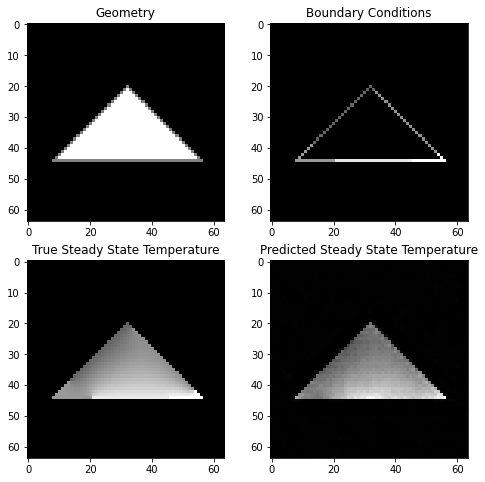

In [ ]:
#Visualising a sample to see if the model is accurate
n=1
predicted=autoencoder.predict(xTest[n].reshape((1,64,64,2)))

plt.figure(figsize=[8,8])
plt.subplot(2,2,1)
plt.imshow(xTest[n,:,:,0],cmap='gray')
plt.title("Geometry")
plt.subplot(2,2,2)
plt.imshow(xTest[n,:,:,1],cmap='gray')
plt.title("Boundary Conditions")
plt.subplot(2,2,3)
plt.imshow(yTest[n,:,:,0],cmap='gray')
plt.title("True Steady State Temperature")
plt.subplot(2,2,4)
plt.imshow(predicted[0,:,:,0],cmap='gray')
plt.title("Predicted Steady State Temperature")
plt.show()

In [ ]:
#Loss value of model on test data
Loss_tanh_test=autoencoder.test_on_batch(xTest[0:1000],yTest[0:1000])
print(Loss_tanh_test)

#Loss value of model on train data
Loss_tanh_train=autoencoder.test_on_batch(xTrain[0:1000],yTrain[0:1000])
print(Loss_tanh_train)

0.001153799588792026
0.001143763423897326


### Sigmoid Activation Fn

In [ ]:
#Constructing the autoencoder model with feed-forward residual block and mse loss function and adam optimizer and sigmoid activation function
ip = Input(shape=(64, 64, 2))

enc = Residual_encoder(16)(ip,sigmoid)
enc = Residual_encoder(32,2)(enc,sigmoid)
enc = Residual_encoder(64,2)(enc,sigmoid)
enc = Residual_encoder(128,2)(enc,sigmoid)
enc_op = Residual_encoder(256,2)(enc,sigmoid)

dec = Residual_decoder(128,2)(enc_op,sigmoid)
dec = Residual_decoder(64,2)(dec,sigmoid)
dec = Residual_decoder(32,2)(dec,sigmoid)
dec = Residual_decoder(16,2)(dec,sigmoid)
dec = Residual_decoder(1)(dec,sigmoid)
dec_op = sigmoid(dec)

autoencoder = Model(ip, dec_op)
autoencoder.compile(optimizer='adam', loss='mse') 

In [ ]:
#Model summary
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 2)]       0         
_________________________________________________________________
residual_encoder_10 (Residua (None, 64, 64, 16)        2752      
_________________________________________________________________
residual_encoder_11 (Residua (None, 32, 32, 32)        14688     
_________________________________________________________________
residual_encoder_12 (Residua (None, 16, 16, 64)        58048     
_________________________________________________________________
residual_encoder_13 (Residua (None, 8, 8, 128)         230784    
_________________________________________________________________
residual_encoder_14 (Residua (None, 4, 4, 256)         920320    
_________________________________________________________________
residual_decoder_10 (Residua (None, 8, 8, 128)         4780

In [ ]:
#Fit the model to the given training data
autoencoder.fit(x=xTrain,y=yTrain,validation_data=(xValidation,yValidation),epochs=3)

Epoch 1/3
966/966 [==============================] - 1377s 1s/step - loss: 0.0423 - val_loss: 0.0445
Epoch 2/3
966/966 [==============================] - 1384s 1s/step - loss: 0.0044 - val_loss: 0.0554
Epoch 3/3
966/966 [==============================] - 1372s 1s/step - loss: 0.0025 - val_loss: 0.0170


In [ ]:
#Saving the weights of the trained model
autoencoder.save_weights('./ResNet_sigmoid.h5')

In [ ]:
#Run this code to load the trained weights
#autoencoder.load_weights('./ResNet_sigmoid.h5')

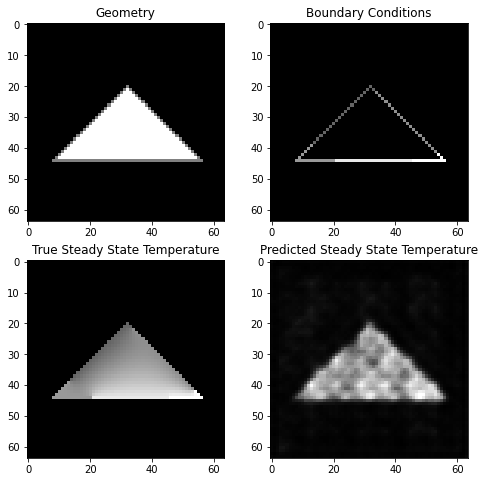

In [ ]:
#Visualising a sample to see if the model is accurate
n=1
predicted=autoencoder.predict(xTest[n].reshape((1,64,64,2)))

plt.figure(figsize=[8,8])
plt.subplot(2,2,1)
plt.imshow(xTest[n,:,:,0],cmap='gray')
plt.title("Geometry")
plt.subplot(2,2,2)
plt.imshow(xTest[n,:,:,1],cmap='gray')
plt.title("Boundary Conditions")
plt.subplot(2,2,3)
plt.imshow(yTest[n,:,:,0],cmap='gray')
plt.title("True Steady State Temperature")
plt.subplot(2,2,4)
plt.imshow(predicted[0,:,:,0],cmap='gray')
plt.title("Predicted Steady State Temperature")
plt.show()

In [ ]:
#Loss value of model on test data
Loss_sigmoid_test=autoencoder.test_on_batch(xTest[0:1000],yTest[0:1000])
print(Loss_sigmoid_test)

#Loss value of model on train data
Loss_sigmoid_train=autoencoder.test_on_batch(xTrain[0:1000],yTrain[0:1000])
print(Loss_sigmoid_train)

0.017036594450473785
0.017630619928240776


#Comparison

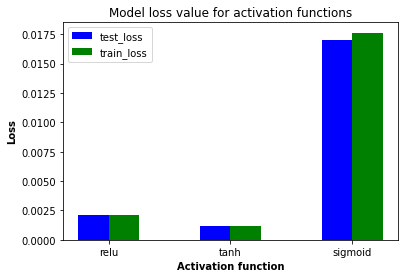

In [ ]:
train_loss=[Loss_ReLu_train, Loss_tanh_train, Loss_sigmoid_train]
test_loss=[Loss_ReLu_test, Loss_tanh_test, Loss_sigmoid_test]
 
br1 = np.arange(3) 
br2 = [x + 0.25 for x in br1] 
 
plt.bar(br1, test_loss, color ='b', width = 0.25, label ='test_loss') 
plt.bar(br2, train_loss, color ='g', width = 0.25, label ='train_loss')  
  
plt.xlabel('Activation function', fontweight ='bold') 
plt.ylabel('Loss', fontweight ='bold') 
plt.xticks([r + 0.125 for r in range(len(train_loss))], ['relu', 'tanh', 'sigmoid']) 
plt.title("Model loss value for activation functions")
plt.legend()
plt.show() 